In [1]:
import tensorflow as tf
import numpy as np
from functools import partial

input_shape = (28, 28, 1)
height, width, n_channels = input_shape

conv_layer = partial(tf.keras.layers.Conv2D,
                     kernel_size=(3,3),
                     padding='same',
                     activation='elu')
maxpooling_layer = partial(tf.keras.layers.MaxPool2D,
                           pool_size=(2,2),
                           strides=(2,2),
                           padding='same')
upsampling_layer = partial(tf.keras.layers.UpSampling2D,
                           size=(2,2))

model = tf.keras.models.Sequential()
model.add(conv_layer(input_shape=input_shape,
                     filters=32,
                     name='encoder_conv1'))
model.add(conv_layer(input_shape=input_shape,
                     filters=32,
                     name='encoder_conv2'))
model.add(maxpooling_layer(name='encoder_maxpooling1'))
model.add(tf.keras.layers.Dropout(0.25, name='encoder_dropout1'))
model.add(conv_layer(filters=64,
                     name='encoder_conv3'))
model.add(conv_layer(filters=64,
                     name='encoder_conv4'))
model.add(maxpooling_layer(name='encoder_maxpooling2'))
model.add(tf.keras.layers.Dropout(0.25, name='encoder_dropout2'))

model.add(tf.keras.layers.Flatten(name='flatten'))

def binary_relaxation_term(weights, beta=1e-2):
    ''' To make sparse and well distributed binary codings. '''
    return beta * tf.reduce_sum(tf.linalg.norm(tf.abs(weights) - 1, axis=1))

model.add(tf.keras.layers.Dense(30,
                                activation='tanh',
                                kernel_regularizer=binary_relaxation_term,
                                name='latent_vector'))

encoder_output_shape = tf.keras.backend.int_shape(model.get_layer('flatten').output)
last_conv_shape = tf.keras.backend.int_shape(model.get_layer('encoder_maxpooling2').output)

model.add(tf.keras.layers.Dense(encoder_output_shape[1], activation='elu', name='inverse_flatten'))
model.add(tf.keras.layers.Reshape((last_conv_shape[1],
                                   last_conv_shape[2],
                                   last_conv_shape[3]), name='reshape'))

model.add(upsampling_layer(name='decoder_upsampling1'))
model.add(tf.keras.layers.Dropout(0.25, name='decoder_dropout1'))
model.add(conv_layer(filters=64,
                     name='decoder_conv1'))
model.add(conv_layer(filters=64,
                     name='decoder_conv2'))
model.add(upsampling_layer(name='decoder_upsampling2'))
model.add(tf.keras.layers.Dropout(0.25, name='decoder_dropout2'))
model.add(conv_layer(filters=32,
                     name='decoder_conv3'))
model.add(conv_layer(filters=32,
                     name='decoder_conv4'))
model.add(conv_layer(filters=1,
                     name='outputs'))

W0909 22:24:44.725461 140628488132416 deprecation.py:506] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 28, 28, 32)        9248      
_________________________________________________________________
encoder_maxpooling1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_dropout1 (Dropout)   (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_conv4 (Conv2D)       (None, 14, 14, 64)        36928     
_________________________________________________________________
encoder_maxpooling2 (MaxPool (None, 7, 7, 64)          0

In [3]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [4]:
from sklearn.preprocessing import MinMaxScaler

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(len(y_train), -1).astype(np.float32)
X_test = X_test.reshape(len(y_test), -1).astype(np.float32)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train).reshape(-1, height, width, n_channels)
X_test = scaler.transform(X_test).reshape(-1, height, width, n_channels)

In [5]:
def add_gaussian_noise(X, noise_level=0.5):
    return X + noise_level * np.random.normal(size=X.shape)

X_train_noisy = add_gaussian_noise(X_train, noise_level=1.0)
X_test_noisy = add_gaussian_noise(X_test, noise_level=1.0)

In [6]:
model_path = './semantic_hashing_autoencoder.h5'
model_saver = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=0, save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0)

n_epochs = 50
batch_size = 1024

model.fit(x=X_train_noisy, y=X_train,
          epochs=n_epochs, batch_size=batch_size,
          shuffle=True, validation_data=(X_test_noisy, X_test),
          callbacks=[model_saver, early_stopper])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 31s 514us/sample - loss: 163.3144 - acc: 0.7962 - val_loss: 158.1862 - val_acc: 0.7996
Epoch 2/50
60000/60000 [==============================] - 26s 431us/sample - loss: 153.2717 - acc: 0.7991 - val_loss: 148.1038 - val_acc: 0.8033
Epoch 3/50
60000/60000 [==============================] - 26s 433us/sample - loss: 143.1781 - acc: 0.8006 - val_loss: 138.0018 - val_acc: 0.8026
Epoch 4/50
60000/60000 [==============================] - 26s 432us/sample - loss: 133.0715 - acc: 0.8009 - val_loss: 127.8914 - val_acc: 0.8041
Epoch 5/50
60000/60000 [==============================] - 26s 432us/sample - loss: 122.9585 - acc: 0.8012 - val_loss: 117.7761 - val_acc: 0.8034
Epoch 6/50
60000/60000 [==============================] - 27s 447us/sample - loss: 112.8415 - acc: 0.8016 - val_loss: 107.6581 - val_acc: 0.8049
Epoch 7/50
60000/60000 [==============================] - 27s 457us/sample - los

In [7]:
latent_vector = model.get_layer('latent_vector').output

hash_functor = tf.keras.Model(inputs=model.input,
                              outputs=latent_vector)
hash_functor.trainable = False

In [12]:
latent_vectors_test = hash_functor.predict(X_test, batch_size=1024)

In [86]:
def latent_vectors_to_hasing_codes(latent_vectors):
    hashing_codes = np.zeros(shape=latent_vectors.shape, dtype='int64')
    hashing_codes[latent_vectors <= 0] = 0
    hashing_codes[latent_vectors > 0] = 1
    return hashing_codes

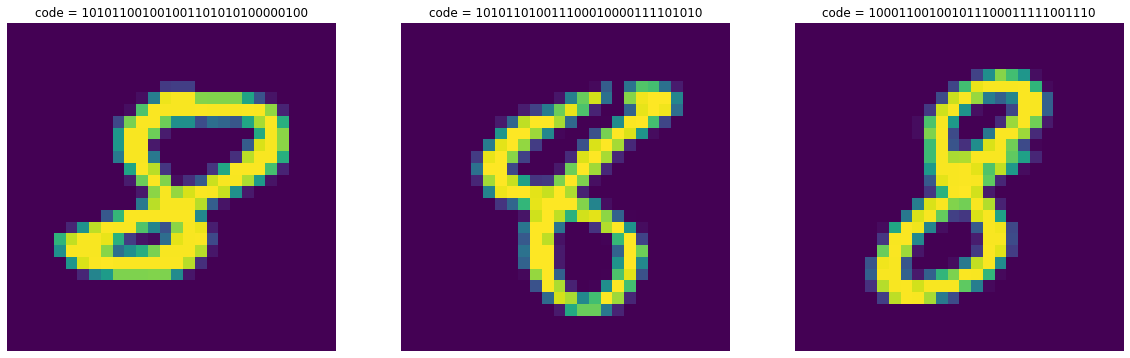

In [90]:
import matplotlib.pyplot as plt

hashing_codes_test = latent_vectors_to_hasing_codes(latent_vectors_test)

partial_class_idx = np.where(y_test == 8)[0]

samples = X_test[partial_class_idx]
labels = y_test[partial_class_idx]
hashing_codes = hashing_codes_test[partial_class_idx]

plt.figure(figsize=(20,10))
for sample, label, code, subplot_idx in zip(samples[:3],
                                            labels[:3],
                                            hashing_codes[:3], [131, 132, 133]):
    plt.subplot(subplot_idx)
    plt.title('code = {}'.format(''.join(map(str,code))))
    plt.imshow(sample.reshape(28,28))
    plt.axis('off')
plt.show()

In [100]:
def sum_distance(ref, vectors):
    return np.sum(np.square(vectors - ref))

print(sum_distance(hashing_codes[0], hashing_codes))

11242


In [101]:
# Need to visualize digit-cluster

for digit_label in range(10):
    other_partial_class_idx = np.where(y_test == digit_label)[0]
    other_codes = hashing_codes_test[other_partial_class_idx]
    print('label={}, sum_distance={}'.format(digit_label, sum_distance(hashing_codes[0], other_codes)))

label=0, sum_distance=12395
label=1, sum_distance=15287
label=2, sum_distance=12332
label=3, sum_distance=15824
label=4, sum_distance=12351
label=5, sum_distance=11815
label=6, sum_distance=12302
label=7, sum_distance=14097
label=8, sum_distance=11242
label=9, sum_distance=12602
